In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Test")

In [4]:
!pip install rasterio
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 64.9 MB/s eta 0:00:00


In [5]:
import os
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
#tf.set_random_seed(29)
#tf.random.set_seed(29)

%matplotlib inline

# Train dataset

In [6]:
#Import raster and mask
raster_path = "N2017.jp2"
src = rasterio.open(raster_path)
raster_img = reshape_as_image(src.read())
raster_meta = src.meta

train_df = gpd.read_file("Nantou.shp")
train_df = train_df[~train_df.geometry.is_empty & train_df.geometry.notna()] #Remove rows without geometry
#train_df

In [7]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []

    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):

        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))

    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry'].geoms:  # Use geoms attribute to iterate over individual polygons
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)
np.unique(mask)

<ipython-input-7-c70abcbadbec>:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


array([0, 1], dtype=uint8)

In [8]:
raster_img.shape

(23342, 21641, 3)

In [ ]:
plt.figure(figsize=(20, 20))

plt.imshow(cv2.cvtColor(raster_img, cv2.COLOR_BGR2RGB))
plt.title('')

plt.tight_layout()
#plt.savefig("mask.png")
plt.show()

In [9]:
#divided image to 3 parts
height, width, channels = raster_img.shape
third_height = height // 3

top_section = raster_img[:third_height, :]
middle_section = raster_img[third_height:2*third_height, :]

bottom_section = raster_img[2*third_height:, :]

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(311)
plt.imshow(cv2.cvtColor(top_section, cv2.COLOR_BGR2RGB))
plt.title('Top Section')

plt.subplot(312)
plt.imshow(cv2.cvtColor(middle_section, cv2.COLOR_BGR2RGB))
plt.title('Middle Section')

plt.subplot(313)
plt.imshow(cv2.cvtColor(bottom_section, cv2.COLOR_BGR2RGB))
plt.title('Bottom Section')

plt.tight_layout()
plt.axis('off')
#plt.savefig("2017_image.png")
plt.show()

In [10]:
mask.shape

(23342, 21641)

In [ ]:
plt.figure(figsize=(20, 20))

plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.tight_layout()
#plt.savefig("mask.png")
plt.show()

In [11]:
#divided image to 3 parts
height, width = mask.shape
third_height = height // 3

top_mask = mask[:third_height, :]
middle_mask = mask[third_height:2*third_height, :]
bottom_mask = mask[2*third_height:, :]

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(311)
plt.imshow(top_mask, cmap='gray')
plt.title('Top Section')

plt.subplot(312)
plt.imshow(middle_mask, cmap='gray')
plt.title('Middle Section')

plt.subplot(313)
plt.imshow(bottom_mask, cmap='gray')
plt.title('Bottom Section')

plt.tight_layout()
#plt.savefig("mask_image.png")
plt.show()

In [ ]:
# 切割影像
height, width, channels = raster_img.shape
third_height = height // 3

top_section = raster_img[:third_height, :]
middle_section = raster_img[third_height:2 * third_height, :]
bottom_section = raster_img[2 * third_height:, :]

plt.figure(figsize=(20, 20))

# 劃出三等分的線
plt.axhline(third_height, color='red', linewidth=2)
plt.axhline(2 * third_height, color='red', linewidth=2)


# 在 X_train 區域的上下左右增加水平線和垂直線，無重叠
for i in range(0, top_section.shape[0] - 256, 256):
    for j in range(0, top_section.shape[1] - 256, 256):
        x_start = j
        x_end = j + 256
        y_start = i
        y_end =  i + 256

        # 增加水平線
        plt.axhline(y_start, color='black', linewidth=0.5)
        plt.axhline(y_end, color='black', linewidth=0.5)

        # 增加垂直線
        plt.axvline(x_start, color='black', linewidth=0.5)
        plt.axvline(x_end, color='black', linewidth=0.5)

# 在 X_train 區域的上下左右增加水平線和垂直線，無重叠
for i in range(128, top_section.shape[0] - 256, 256):
    for j in range(128, top_section.shape[1] - 256, 256):
        x_start = j
        x_end = j + 256
        y_start = i
        y_end =  i+256

        # 增加水平線
        plt.axhline(y_start, color='yellow', linewidth=0.5)

        # 確保黃色垂直線不超過top_section的底部
        if y_end <= top_section.shape[0]:
            plt.axhline(y_end, color='yellow', linewidth=0.5)

        # 增加垂直線
        if x_end <= top_section.shape[1]:
            for y in range(y_start, y_end, 256):
                plt.axvline(x_start, color='yellow', linewidth=0.5)
                plt.axvline(x_end, color='yellow', linewidth=0.5)



# 在 X_valid 區域的上下左右增加水平線和垂直線，無重叠
for i in range(0, middle_section.shape[0] - 256, 256):
    for j in range(0, middle_section.shape[1] - 256, 256):
        x_start = j
        x_end = j + 256
        y_start = third_height + i
        y_end = third_height + i + 256

        # 增加水平線
        plt.axhline(y_start, color='black', linewidth=0.5)
        plt.axhline(y_end, color='black', linewidth=0.5)

        # 增加垂直線
        plt.axvline(x_start, color='black', linewidth=0.5)
        plt.axvline(x_end, color='black', linewidth=0.5)

# 在 X_test 區域的上下左右增加水平線和垂直線，無重叠
for i in range(0, bottom_section.shape[0] - 256, 256):
    for j in range(0, bottom_section.shape[1] - 256, 256):
        x_start = j
        x_end = j + 256
        y_start = 2 * third_height + i
        y_end = 2 * third_height + i + 256

        # 增加水平線
        plt.axhline(y_start, color='black', linewidth=0.5)
        plt.axhline(y_end, color='black', linewidth=0.5)

        # 增加垂直線
        plt.axvline(x_start, color='black', linewidth=0.5)
        plt.axvline(x_end, color='black', linewidth=0.5)

# 顯示完整影像
plt.imshow(cv2.cvtColor(raster_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

#plt.savefig("image1.png")
plt.show()

In [ ]:
#Split the large image into patches of 256x256
patch_size = 256
overlap = 128

# List to store small image patches
X_train = []
y_train = []
# Divide the large image into patches
height, width, _ = top_section.shape

for i in range(0, height - patch_size, overlap):
    for j in range(0, width - patch_size, overlap):
        patch = top_section[i:i+patch_size, j:j+patch_size]
        X_train.append(patch)
        patch1 = top_mask[i:i+patch_size, j:j+patch_size]
        y_train.append(patch1)

# Display the number of patches created
num_patches1 = len(X_train)
print("Number of top patches:", num_patches1)
num_patches2 = len(y_train)
print("Number of top mask patches:", num_patches2)

In [12]:
#Split the large image into patches of 256x256
y_train = []
X_train = []
for i1 in range(0, len(top_mask) - 256, 128):
    for j1 in range(0, len(top_mask) - 256, 128):
        m1 = top_mask[i1: i1 + 256, j1: j1 + 256]
        r1 = top_section[i1: i1 + 256, j1: j1 + 256]
        _, counts = np.unique(m1, return_counts=True)

        if counts.size != 0 and (counts[0] / counts.sum() < 0.99):
            y_train.append(m1)
            X_train.append(r1)
len(X_train)

384

In [ ]:
#increase number of images by flipped and rotatated images
for i in range(len(y_train)):
    y_train.append(np.fliplr(y_train[i]))
    X_train.append(np.fliplr(X_train[i]))
for i in range(len(y_train)):
    y_train.append(np.rot90(y_train[i]))
    X_train.append(np.rot90(X_train[i]))
len(y_train), len(X_train)

In [ ]:
#Split the large image into patches of 256x256
patch_size = 256
overlap = 256

# List to store small image patches
X_valid = []
y_valid = []
# Divide the large image into patches
height, width, _ = middle_section.shape

for i in range(0, height - patch_size, overlap):
    for j in range(0, width - patch_size, overlap):
        patch = middle_section[i:i+patch_size, j:j+patch_size]
        X_valid.append(patch)
        patch1 = middle_mask[i:i+patch_size, j:j+patch_size]
        y_valid.append(patch1)

# Display the number of patches created
num_patches1 = len(X_valid)
print("Number of middle patches:", num_patches1)
num_patches2 = len(y_valid)
print("Number of middle mask patches:", num_patches2)

In [13]:
#Split the large image into patches of 256x256
y_valid = []
X_valid = []
for i1 in range(0, len(middle_mask) - 256, 256):
    for j1 in range(0, len(middle_mask) - 256, 256):
        m1 = middle_mask[i1: i1 + 256, j1: j1 + 256]
        r1 = middle_section[i1: i1 + 256, j1: j1 + 256]
        _, counts = np.unique(m1, return_counts=True)
        if counts.size != 0 and (counts[0] / counts.sum() < 0.99):
            y_valid.append(m1)
            X_valid.append(r1)

len(X_valid)

40

In [ ]:
#Split the large image into patches of 256x256
patch_size = 256
overlap = 256

# List to store small image patches
X_test = []
y_test = []
# Divide the large image into patches
height, width, _ = bottom_section.shape

for i in range(0, height - patch_size, overlap):
    for j in range(0, width - patch_size, overlap):
        patch = bottom_section[i:i+patch_size, j:j+patch_size]
        X_test.append(patch)
        patch1 = bottom_mask[i:i+patch_size, j:j+patch_size]
        y_test.append(patch1)

# Display the number of patches created
num_patches1 = len(X_test)
print("Number of bottom patches:", num_patches1)
num_patches2 = len(y_test)
print("Number of bottom mask patches:", num_patches2)

In [14]:
#Split the large image into patches of 256x256
y_test = []
X_test = []
for i2 in range(0, len(bottom_mask) - 256, 256):
   for j2 in range(0, len(bottom_mask) - 256, 256):
        m2 = bottom_mask[i2: i2 + 256, j2: j2 + 256]
        r2 = bottom_section[i2: i2 + 256, j2: j2 + 256]
        _, counts = np.unique(m2, return_counts=True)
        if counts.size != 0 and (counts[0] / counts.sum() < 0.99):
            y_test.append(m2)
            X_test.append(r2)

len(X_test)

8

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(X_test[0])
plt.subplot(132)
plt.imshow(y_test[0])

plt.show()

In [ ]:
# y_train = masks[0:303]
# X_train = rasters[0:303]

# y_test = masks[303:606]
# X_test = rasters[303:606]

# y_valid = masks[606:909]
# X_valid = rasters[606:909]

# len(y_train), len(X_train),len(y_valid), len(X_valid),len(y_valid), len(X_valid)

In [15]:
############### Unet model ##################

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = 'sigmoid'

    outputs = Conv2D(1, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
input_shape = (256, 256, 3)
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [17]:
from tensorflow.keras.metrics import MeanIoU

model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalizat

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(rasters, masks, test_size = 0.1)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [18]:
#Check the array of each images after divided
for index, element in enumerate(y_valid):
   print(f"Shape of element {index + 1}: {element.shape}")

Shape of element 1: (256, 256)
Shape of element 2: (256, 256)
Shape of element 3: (256, 256)
Shape of element 4: (256, 256)
Shape of element 5: (256, 256)
Shape of element 6: (256, 256)
Shape of element 7: (256, 256)
Shape of element 8: (256, 256)
Shape of element 9: (256, 256)
Shape of element 10: (256, 256)
Shape of element 11: (256, 256)
Shape of element 12: (256, 256)
Shape of element 13: (256, 256)
Shape of element 14: (256, 256)
Shape of element 15: (256, 256)
Shape of element 16: (256, 256)
Shape of element 17: (256, 256)
Shape of element 18: (256, 256)
Shape of element 19: (256, 256)
Shape of element 20: (256, 256)
Shape of element 21: (256, 256)
Shape of element 22: (256, 256)
Shape of element 23: (256, 256)
Shape of element 24: (256, 256)
Shape of element 25: (256, 256)
Shape of element 26: (256, 256)
Shape of element 27: (256, 256)
Shape of element 28: (256, 256)
Shape of element 29: (256, 256)
Shape of element 30: (256, 256)
Shape of element 31: (256, 256)
Shape of element 

In [ ]:
# #Only keep the image with them same size 256z256
# X_test = [arr for arr in X_test if arr.shape == (256,256,3)]
# y_test = [arr for arr in y_test if arr.shape == (256,256)]
# X_train = [arr for arr in X_train if arr.shape == (256,256,3)]
# y_train = [arr for arr in y_train if arr.shape == (256,256)]
# X_valid = [arr for arr in X_valid if arr.shape == (256,256,3)]
# y_valid = [arr for arr in y_valid if arr.shape == (256,256)]

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('Landslide_Unet_Largeimage.hdf5')

In [19]:
tf.random.set_seed(29)

In [20]:
#from tensorflow.keras.callbacks import EarlyStopping
v_data = (np.array(X_valid), np.array(y_valid))
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = 16,
                    verbose=1,
                    epochs=20,
                    validation_data=v_data,
                    shuffle=False)
                    #callbacks=[EarlyStopping(patience=10)])

model.save('t1E20.hdf5')

Epoch 1/20
24/24 [==============================] - 36s 333ms/step - loss: 0.3584 - mean_io_u: 0.3403 - val_loss: 9.7537 - val_mean_io_u: 0.1885
Epoch 2/20
24/24 [==============================] - 6s 242ms/step - loss: 0.3210 - mean_io_u: 0.3403 - val_loss: 10.0296 - val_mean_io_u: 0.1713
Epoch 3/20
24/24 [==============================] - 6s 242ms/step - loss: 0.3073 - mean_io_u: 0.3403 - val_loss: 7.7277 - val_mean_io_u: 0.3960
Epoch 4/20
24/24 [==============================] - 6s 242ms/step - loss: 0.2936 - mean_io_u: 0.3403 - val_loss: 0.8629 - val_mean_io_u: 0.3289
Epoch 5/20
24/24 [==============================] - 6s 242ms/step - loss: 0.2829 - mean_io_u: 0.3403 - val_loss: 1.4028 - val_mean_io_u: 0.4594
Epoch 6/20
24/24 [==============================] - 6s 243ms/step - loss: 0.2745 - mean_io_u: 0.3403 - val_loss: 1.0210 - val_mean_io_u: 0.3375
Epoch 7/20
24/24 [==============================] - 6s 243ms/step - loss: 0.2710 - mean_io_u: 0.3403 - val_loss: 4.8733 - val_mean_io_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
preds= model.predict(np.array(X_test))

1/1 [==============================] - 0s 450ms/step


In [22]:
pred_bin = preds[:, :, :, 0] > 0.5
loss = MeanIoU(num_classes=2)
loss.update_state(y_test, pred_bin)
loss.result().numpy()

0.51284003

In [ ]:
f, axarr = plt.subplots(2, 4)
f.set_size_inches(20, 10)
for i in range(len(y_test)):
  axarr[i // 4, i % 4].imshow(y_test[i])

In [ ]:
f, axarr = plt.subplots(2, 2)
f.set_size_inches(10, 10)
for i in range(min(len(X_test), 4)):
  axarr[i // 2, i % 2].imshow(X_test[i])
  axarr[i // 2, i % 2].axis('off')

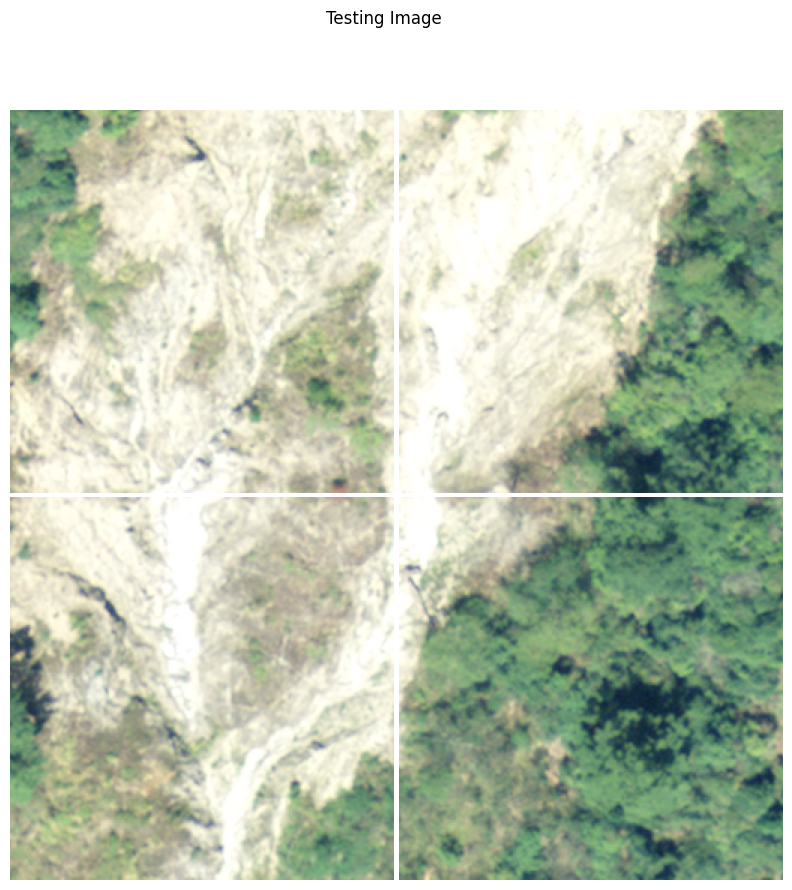

In [24]:
f, axarr = plt.subplots(2, 2)  # 創建一個2x2的網格用於顯示前4個圖像
f.set_size_inches(10, 10)  # 設置圖片大小

f.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(min(len(X_test[i]), 4)):
    axarr[i // 2, i % 2].imshow(X_test[i])
    axarr[i // 2, i % 2].axis('off')
plt.suptitle('Testing Image')
plt.show()

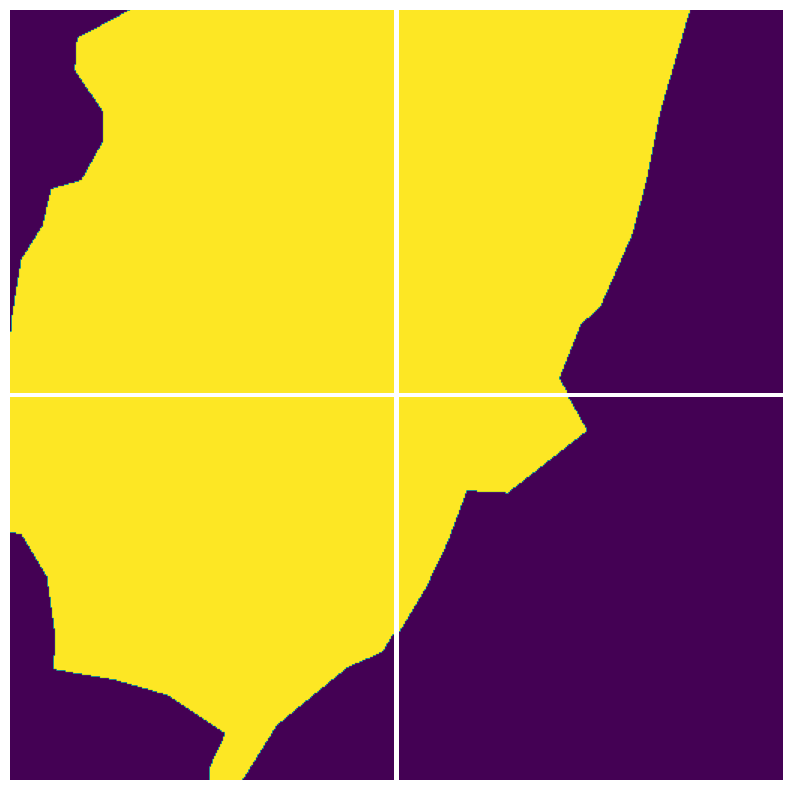

In [25]:
f, axarr = plt.subplots(2, 2)  # 創建一個2x2的網格用於顯示前4個圖像
f.set_size_inches(10, 10)  # 設置圖片大小

f.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(min(len(y_test[i]), 4)):
    axarr[i // 2, i % 2].imshow(y_test[i])
    axarr[i // 2, i % 2].axis('off')

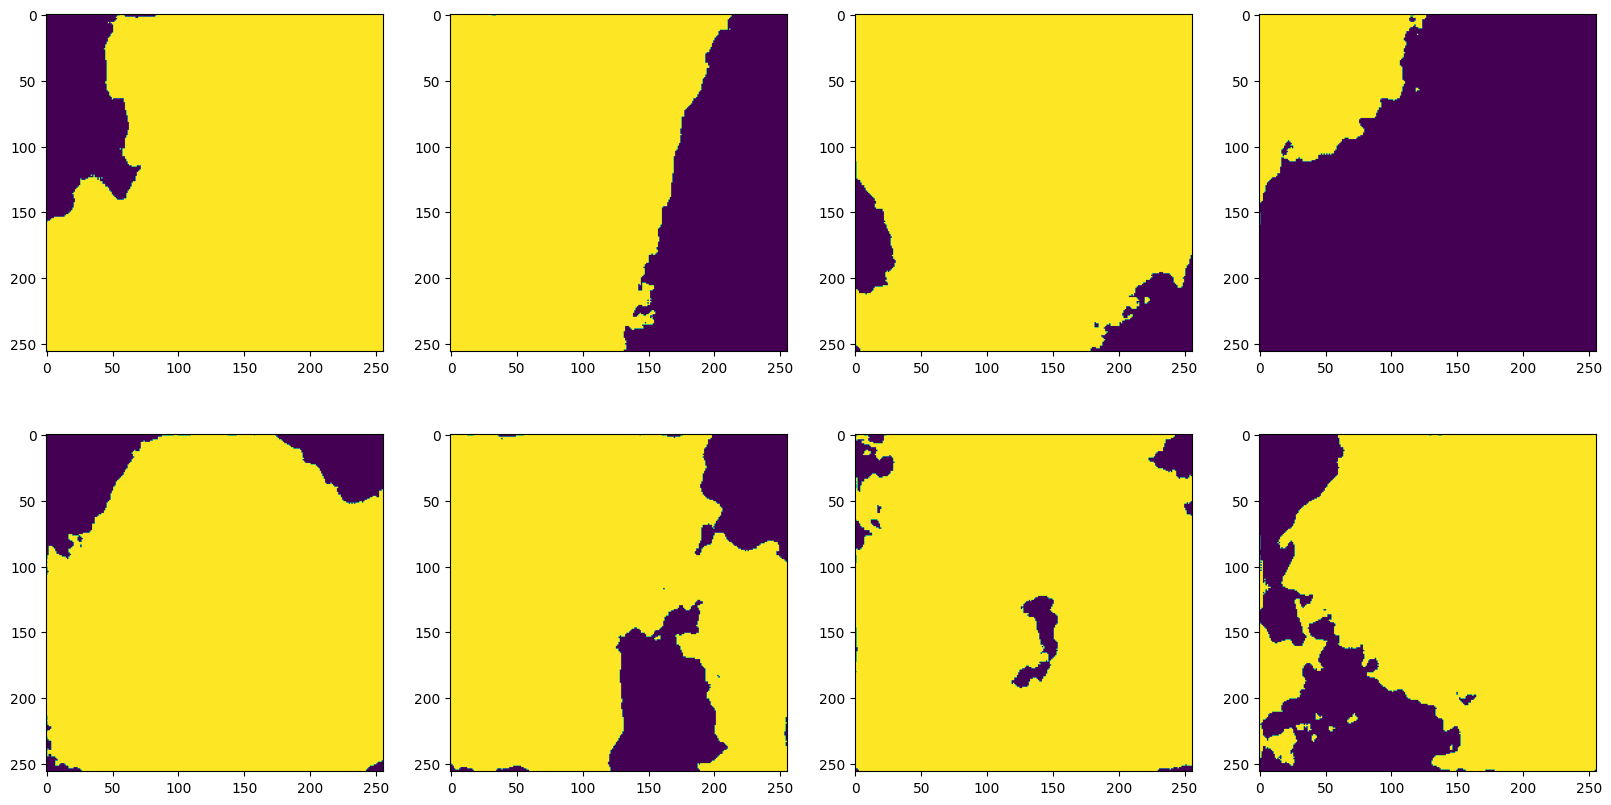

In [29]:
f, axarr = plt.subplots(2, 4)
f.set_size_inches(20, 10)
for i in range(len(preds)):
  axarr[i // 4, i % 4].imshow(preds[i][:, :] > 0.5)

In [ ]:
f, axarr = plt.subplots(2, 2)  # 創建一個2x2的網格用於顯示前4個圖像
f.set_size_inches(10, 10)  # 設置圖片大小

for i in range(min(len(preds), 4)):  # 遍歷前4個圖像，或者更少如果'preds'包含少於4個圖像
    axarr[i // 2, i % 2].imshow(preds[i][:, :] > 0.5)  # 顯示圖像，根據需要調整閾值（此處為0.5）
    axarr[i // 2, i % 2].axis('off')

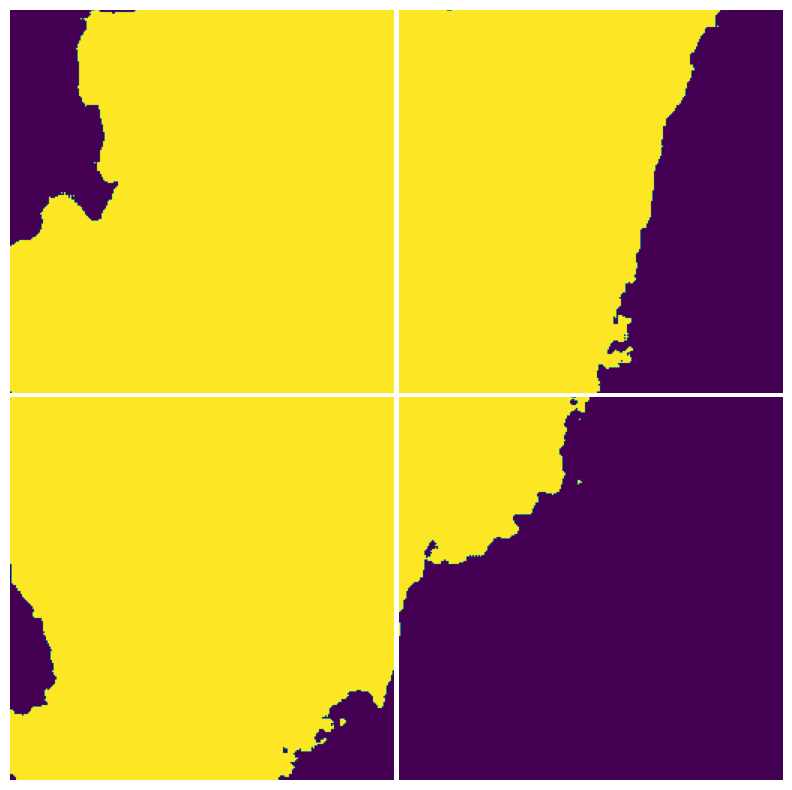

In [27]:
f, axarr = plt.subplots(2, 2)  # 創建一個2x2的網格用於顯示前4個圖像
f.set_size_inches(10, 10)  # 設置圖片大小

f.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(min(len(preds), 4)):
    axarr[i // 2, i % 2].imshow(preds[i][:, :] > 0.5)
    axarr[i // 2, i % 2].axis('off')

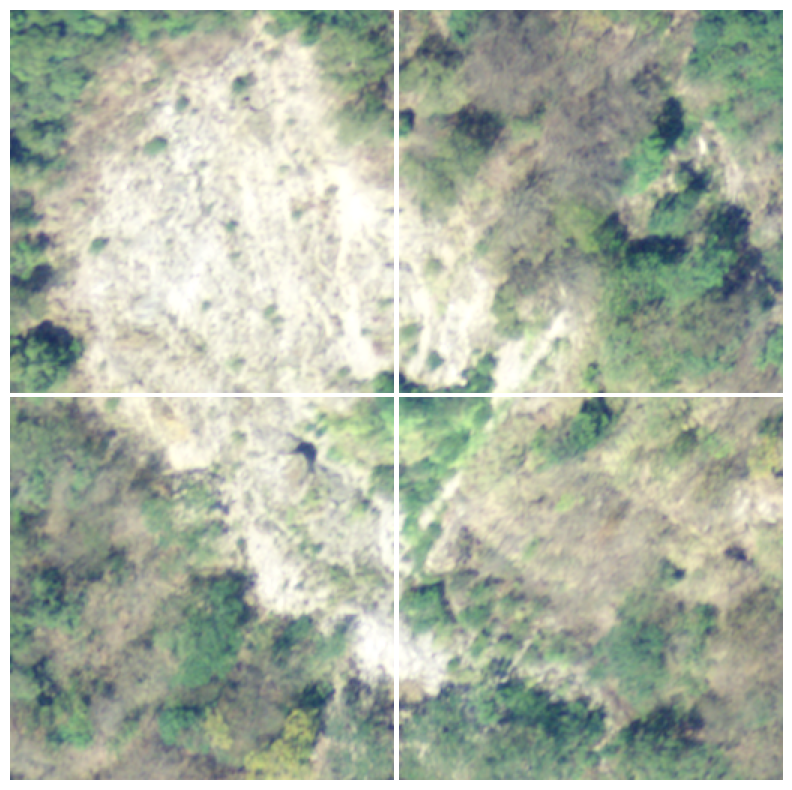

In [28]:
f, axarr = plt.subplots(2, 2)  # 創建一個2x2的網格用於顯示前4個圖像
f.set_size_inches(10, 10)  # 設置圖片大小

f.subplots_adjust(wspace=0.01, hspace=0.01)

# 從'preds'列表中的後四個圖像開始
for i in range(max(0, len(X_test) - 4), len(preds)):
    row = (i - (len(X_test) - 4)) // 2  # 計算行索引
    col = (i - (len(X_test) - 4)) % 2   # 計算列索引
    axarr[row, col].imshow(X_test[i])  # 顯示圖像，根據需要調整閾值（此處為0.5）
    axarr[row, col].axis('off')


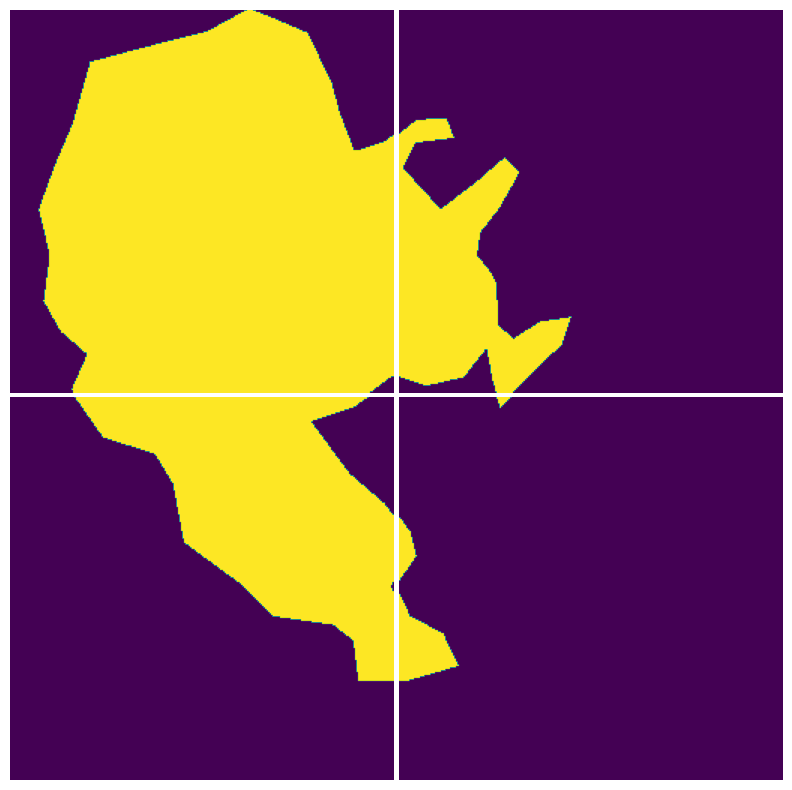

In [30]:
f, axarr = plt.subplots(2, 2)  # 創建一個2x2的網格用於顯示前4個圖像
f.set_size_inches(10, 10)  # 設置圖片大小

f.subplots_adjust(wspace=0.01, hspace=0.01)

# 從'preds'列表中的後四個圖像開始
for i in range(max(0, len(y_test) - 4), len(preds)):
    row = (i - (len(y_test) - 4)) // 2  # 計算行索引
    col = (i - (len(y_test) - 4)) % 2   # 計算列索引
    axarr[row, col].imshow(y_test[i])  # 顯示圖像，根據需要調整閾值（此處為0.5）
    axarr[row, col].axis('off')

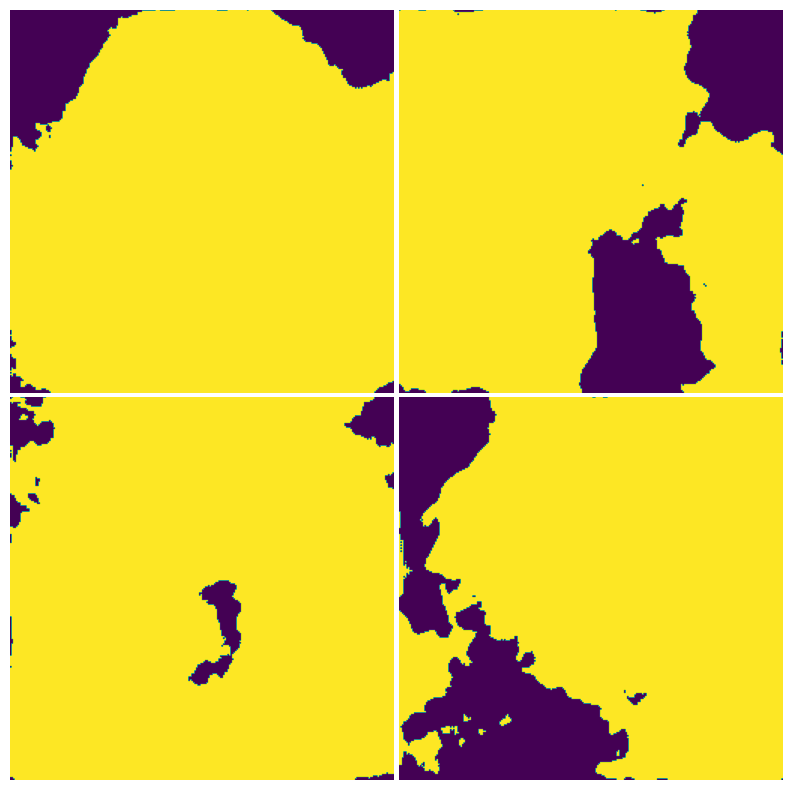

In [32]:
f, axarr = plt.subplots(2, 2)  # 創建一個2x2的網格用於顯示前4個圖像
f.set_size_inches(10, 10)  # 設置圖片大小

f.subplots_adjust(wspace=0.01, hspace=0.01)

# 從'preds'列表中的後四個圖像開始
for i in range(max(0, len(preds) - 4), len(preds)):
    row = (i - (len(preds) - 4)) // 2  # 計算行索引
    col = (i - (len(preds) - 4)) % 2   # 計算列索引
    axarr[row, col].imshow(preds[i][:, :] > 0.5)  # 顯示圖像，根據需要調整閾值（此處為0.5）
    axarr[row, col].axis('off')

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(X_test[1])
plt.subplot(132)
plt.title('Mask')
plt.imshow(y_test[1])
plt.subplot(133)
plt.title('Prediction')
plt.imshow(preds[1][:, :] > 0.5)

plt.show()

In [ ]:
#試1
import matplotlib.pyplot as plt

num_images = len(X_test)  # 總共的數量

plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.title(f'Testing Image {i}')
    plt.imshow(X_test[i])
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.title(f'Mask {i}')
    plt.imshow(y_test[i])
    plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.title(f'Prediction {i}')

    # 預測出有內容的部分（像素值大於0.5）為黃色，其他部分為紫色
    prediction_with_content = preds[i][:, :] > 0.5
    plt.imshow(prediction_with_content)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#試2
import matplotlib.pyplot as plt

num_images = len(X_test)  # 總共的數量

plt.figure(figsize=(20, 10))

for i in range(num_images):
    # 判斷預測圖像中是否有內容，只有當有內容時才顯示
    if np.any(preds[i] > 0.5):
        plt.subplot(3, num_images, i + 1)
        plt.title(f'Testing Image {i}')
        plt.imshow(X_test[i])
        plt.axis('off')

        plt.subplot(3, num_images, num_images + i + 1)
        plt.title(f'Mask {i}')
        plt.imshow(y_test[i])
        plt.axis('off')

        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.title(f'Prediction {i}')
        plt.imshow(preds[i][:, :] > 0.5)
        plt.axis('off')

plt.tight_layout()
plt.show()

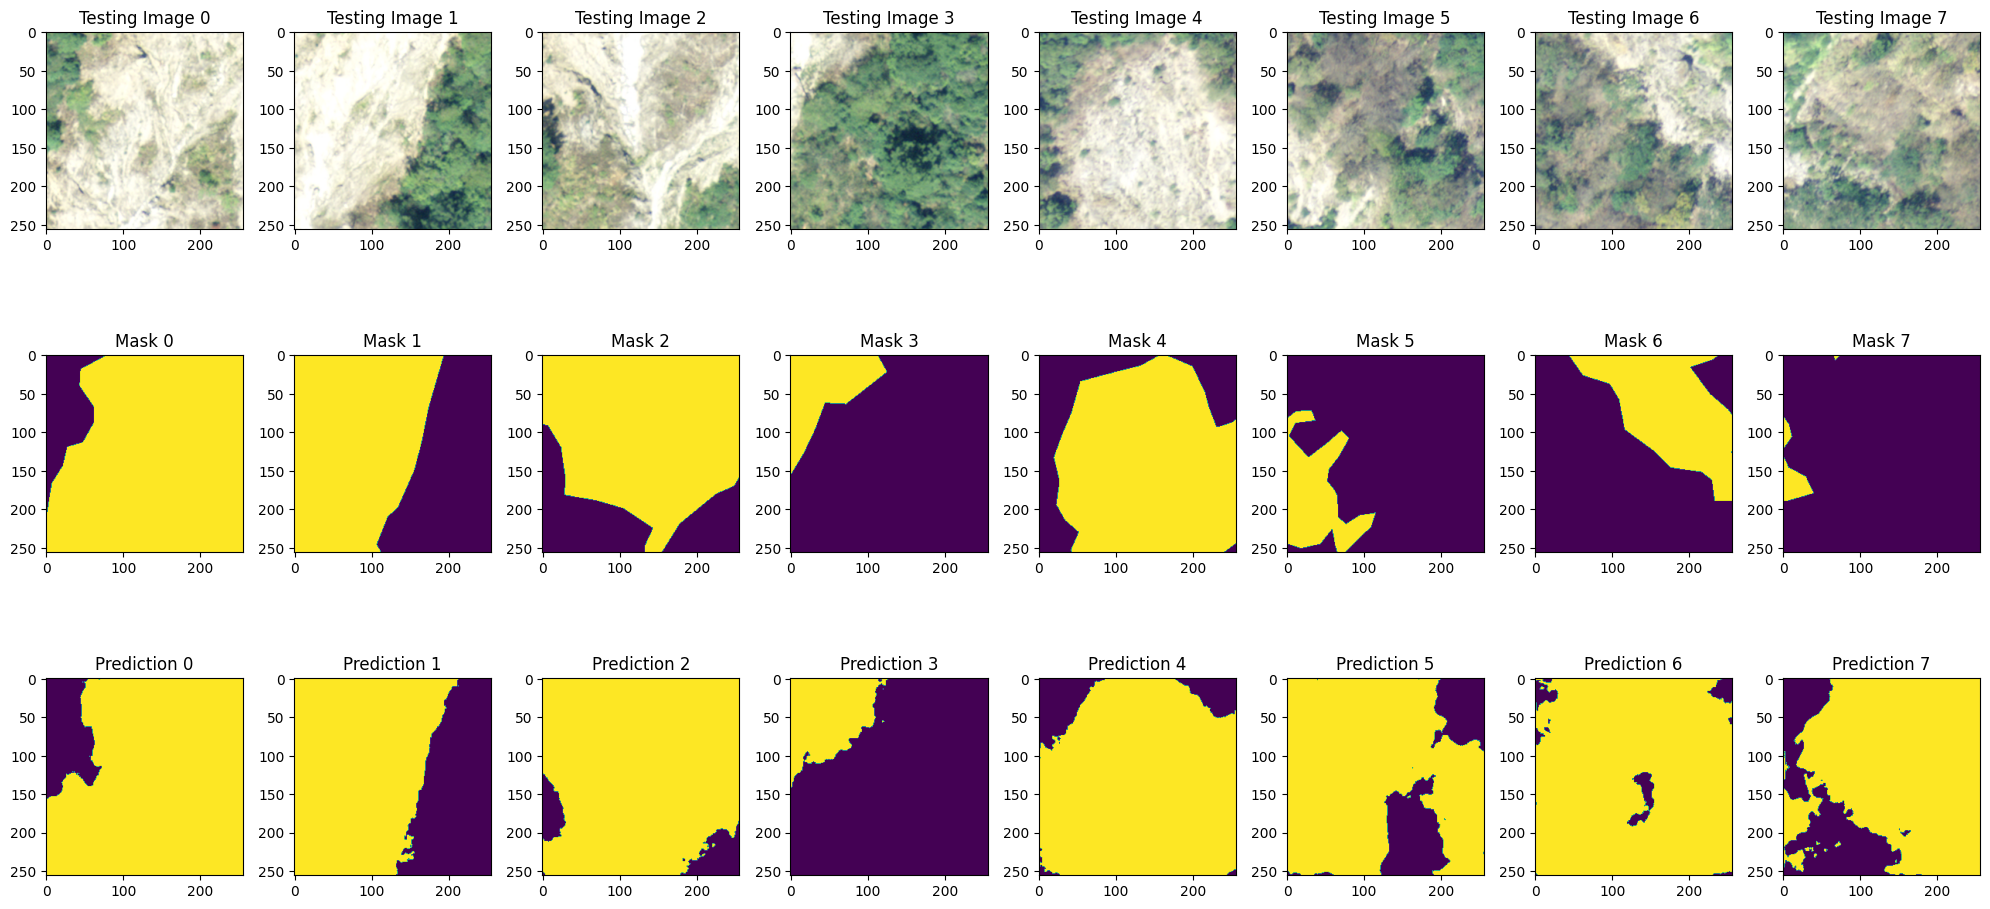

In [23]:
import matplotlib.pyplot as plt

num_images = len(X_test)  # 總共的數量

plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.title(f'Testing Image {i}')
    plt.imshow(X_test[i])
    # plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.title(f'Mask {i}')
    plt.imshow(y_test[i])
    # plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.title(f'Prediction {i}')
    plt.imshow(preds[i][:, :] > 0.5)
    # plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

num_images = len(X_test)  # 總共的數量

plt.figure(figsize=(10, 20))  # 設定整體圖片的大小

for i in range(num_images):
    plt.subplot(num_images, 3, i * 3 + 1)
    if i == 0:
      plt.title('Testing Image')
    plt.imshow(X_test[i])
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 2)
    if i == 0:
      plt.title('Mask')
    plt.imshow(y_test[i])
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 3)
    if i == 0:
      plt.title('Prediction')
    plt.imshow(preds[i][:, :] > 0.5)
    plt.axis('off')
#plt.subplots_adjust(hspace=0.01)
plt.tight_layout()
#plt.savefig("reault_image.png")

plt.show()

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
%%writefile requirements.txt

In [ ]:
import numpy as np
patch_size = 256
overlap = 256
def merge_patches(patches, patch_size, overlap, height, width):
    # Calculate the number of patches in each dimension
    num_patches_rows = (height - patch_size) // overlap + 1
    num_patches_cols = (width - patch_size) // overlap + 1

    # Create an empty large image to store the merged patches
    reconstructed_image = np.zeros((height, width, 1), dtype=np.uint8)

    # Merge the patches back into the original image
    count = 0
    for i in range(num_patches_rows):
        for j in range(num_patches_cols):
            x_start = j * overlap
            y_start = i * overlap
            x_end = x_start + patch_size
            y_end = y_start + patch_size
            reconstructed_image[y_start:y_end, x_start:x_end, :] = np.expand_dims(patches[count], axis=-1)
            count += 1

    return reconstructed_image


# Merge the patches for y_test
merged_test_image = merge_patches(y_test, patch_size, overlap, height, width)

# Display the merged image
plt.figure(figsize=(20, 30))
plt.imshow(merged_test_image)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
patch_size = 256
overlap = 256
def merge_patches(patches, patch_size, overlap, height, width):
    # Calculate the number of patches in each dimension
    num_patches_rows = (height - patch_size) // overlap + 1
    num_patches_cols = (width - patch_size) // overlap + 1

    # Create an empty large image to store the merged patches
    reconstructed_image = np.zeros((height, width, 1), dtype=np.uint8)

    # Merge the patches back into the original image
    count = 0
    for i in range(num_patches_rows):
        for j in range(num_patches_cols):
            x_start = j * overlap
            y_start = i * overlap
            x_end = x_start + patch_size
            y_end = y_start + patch_size
            reconstructed_image[y_start:y_end, x_start:x_end, :] = np.expand_dims(patches[count], axis=-1)
            count += 1

    return reconstructed_image


# Merge the patches for preds
merged_pred_image = merge_patches(pred_bin, patch_size, overlap, height, width)

# Display the merged image
plt.figure(figsize=(20, 30))
plt.imshow(merged_pred_image)
plt.axis('off')
plt.show()

In [ ]:
print(pred_bin.dtype)